# Evaluation Metrics for Classification

In the previous session we trained a model for predicting churn. How do we know if it's good?


- Kaggle: https://www.kaggle.com/blastchar/telco-customer-churn
- Dataset: https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv


[*Metric*](https://developers.google.com/machine-learning/crash-course/classification/accuracy-precision-recall) - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

## Training the Classification Model

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve ,roc_auc_score, classification_report

In [4]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
df = pd.read_csv(url)

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [5]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [6]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [8]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=2000)
model.fit(X_train, y_train)

/opt/miniconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=2000)

In [9]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

## Thresholds

In a binary classification, a number between 0 and 1 that converts the raw output of a logistic regression model into a prediction of either the positive class or the negative class. Note that the classification threshold is a value that a human chooses, not a value chosen by model training.

A logistic regression model outputs a raw value between 0 and 1. Then:

- If this raw value is greater than the classification threshold, then the positive class is predicted.
- If this raw value is less than the classification threshold, then the negative class is predicted.

For example, suppose the classification threshold is 0.8. If the raw value is 0.9, then the model predicts the positive class. If the raw value is 0.7, then the model predicts the negative class.

The choice of classification threshold strongly influences the number of false positives and false negatives.


In [10]:
churn_decision = (y_pred >= 0.5).astype(int)

## Confusion Matrix

There are four possible outcomes for each output from a binary classifier. For the spam classifier example, if you lay out the ground truth as columns and the model's prediction as rows, the following table, called a confusion matrix, is the result:

|                              | **Actual Positive** | **Actual Negative** |
|------------------------------|---------------------|---------------------|
| **Predicted Positive**       | **True positive (TP):** A customer correctly classified as churned.               | **False positive (FP):** A non-churned customer misclassified as churned.                 |
| **Predicted Negative**       | **False negative (FN):** A churned customer misclassified as non-churned.                   | **True negative (TN):** A non-churned customer correctly classified as non-churned.                  |


In [11]:
actual_positive = (y_val == 1)
actual_negatives = (y_val == 0)
print("Total actual positives:", actual_positive.sum())
print("Total actual negatives:", actual_negatives.sum())

Total actual positives: 386
Total actual negatives: 1023


In [12]:
t = 0.5
predicted_positives = (y_pred >= t)
predicted_negatives = (y_pred < t)
print("Total predicted positives:", predicted_positives.sum())
print("Total predicted negatives:", predicted_negatives.sum())

Total predicted positives: 318
Total predicted negatives: 1091


In [13]:
TP = (predicted_positives & actual_positive).sum()
TN = (predicted_negatives & actual_negatives).sum()
FP = (predicted_positives & actual_negatives).sum()
FN = (predicted_negatives & actual_positive).sum()
print("True Positives:", TP)
print("True Negatives:", TN)
print("False Positives:", FP)
print("False Negatives:", FN)

True Positives: 213
True Negatives: 918
False Positives: 105
False Negatives: 173


In [14]:
cnf_matrix = np.array([
    [TN, FP],
    [FN, TP]
])
cnf_matrix

array([[918, 105],
       [173, 213]])

In [15]:
# Confusion matrix normalized
(cnf_matrix / cnf_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

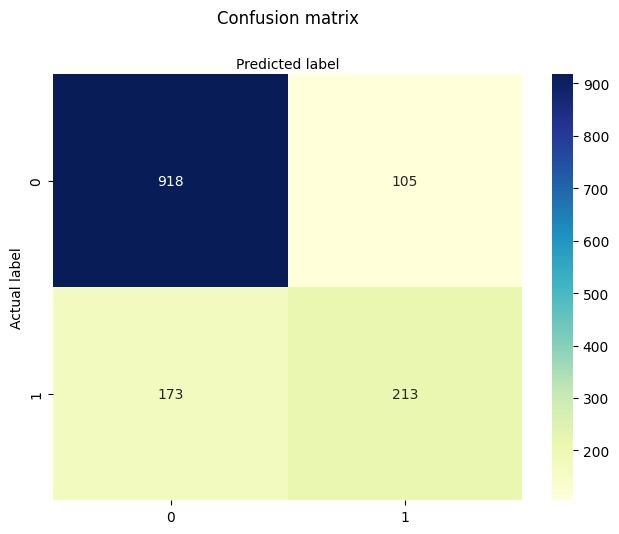

In [16]:
cnf_matrix = confusion_matrix(y_val, churn_decision)

# Plot confusion matrix
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

## Accuracy

Accuracy is the proportion of all classifications that were correct, whether positive or negative. It is mathematically defined as:

![accuracy](./img/image1.png)

In the churn classification example, accuracy measures the fraction of all customer churn correctly classified. A perfect model would have zero false positives and zero false negatives and therefore an accuracy of 1.0, or 100%.

- TP -> True Positive
- TN -> True Negative
- FP -> False Positive
- FN -> False Negative

Because it incorporates all four outcomes from the confusion matrix (TP, FP, TN, FN), given a balanced dataset, with similar numbers of examples in both classes, accuracy can serve as a coarse-grained measure of model quality. For this reason, it is often the default evaluation metric used for generic or unspecified models carrying out generic or unspecified tasks.

However, when the dataset is imbalanced, or where one kind of mistake (FN or FP) is more costly than the other, which is the case in most real-world applications, it's better to optimize for one of the other metrics instead.

For heavily imbalanced datasets, where one class appears very rarely, say 1% of the time, a model that predicts negative 100% of the time would score 99% on accuracy, despite being useless.



In [17]:
# Accuracy = TP + TN / Total
(y_val == churn_decision).mean()

0.8026969481902059

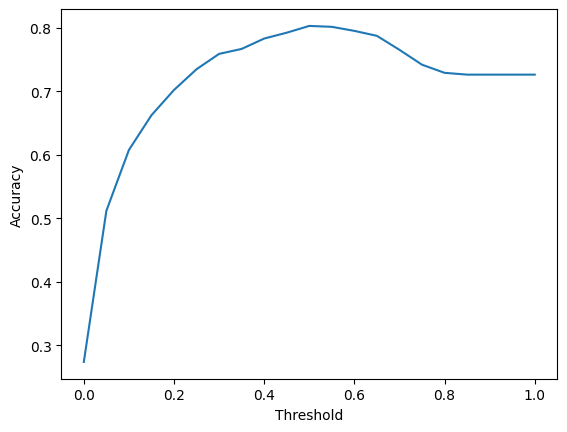

In [18]:
threshold = np.linspace(0, 1, 21)
accuracy = []

for t in threshold:
    churn_decision = (y_pred >= t)
    # acc = (y_val == churn_decision).mean()
    acc = accuracy_score(y_val, churn_decision)
    accuracy.append(acc)

plt.plot(threshold, accuracy)
plt.xlabel('Threshold')
plt.ylabel('Accuracy')
plt.show()

In [19]:
# Check for class imbalance in churn rate
df.churn.value_counts(normalize=True)

churn
0    0.73463
1    0.26537
Name: proportion, dtype: float64

## Recall & Precision

The **true positive rate (TPR)**, or the proportion of all actual positives that were classified correctly as positives, is also known as **recall**. Recall is mathematically defined as:


![Recall](./img/image3.png)

False negatives are actual positives that were misclassified as negatives, which is why they appear in the denominator. In the churn classification example, recall measures the fraction of churned customers that were correctly classified as churned. This is why another name for recall is probability of detection: it answers the question "What fraction of churned customers are detected by this model?"

----
The **false positive rate (FPR)** is the proportion of all actual negatives that were classified incorrectly as positives, also known as the probability of false alarm. It is mathematically defined as:

![FPR](./img/image4.png)

False positives are actual negatives that were misclassified, which is why they appear in the denominator. A perfect model would have zero false positives and therefore a FPR of 0.0, which is to say, a 0% false alarm rate.

----


**Precision** is the proportion of all the model's positive classifications that are actually positive. It is mathematically defined as:

![Precision](./img/image2.png)

In the churn classification example, precision measures the fraction of customers classified as churn that were actually churn.

A hypothetical perfect model would have zero false positives and therefore a precision of 1.0.

In an imbalanced dataset where the number of actual positives is very, very low, say 1-2 examples in total, precision is less meaningful and less useful as a metric.


Precision improves as false positives decrease, while recall improves when false negatives decrease. But as seen in the previous section, increasing the classification threshold tends to decrease the number of false positives and increase the number of false negatives, while decreasing the threshold has the opposite effects. As a result, precision and recall often show an inverse relationship, where improving one of them worsens the other.

In [20]:
precision = TP / (TP + FP)
print("Precision:", precision)

Precision: 0.6698113207547169


In [21]:
recall = TP / (TP + FN)
print("Recall:", recall)

Recall: 0.5518134715025906


In [22]:
churn_decision = (y_pred >= 0.5).astype(int)
target_names = ['no_churn', 'churn']
classification_rprt = classification_report(y_val, churn_decision, target_names=target_names)
print("\nClassification report (threshold=0.5):\n", classification_rprt)


Classification report (threshold=0.5):
               precision    recall  f1-score   support

    no_churn       0.84      0.90      0.87      1023
       churn       0.67      0.55      0.61       386

    accuracy                           0.80      1409
   macro avg       0.76      0.72      0.74      1409
weighted avg       0.79      0.80      0.80      1409



## ROC Curves

The ROC curve is a visual representation of model performance across all thresholds. The long version of the name, receiver operating characteristic, is a holdover from WWII radar detection.

The ROC curve is drawn by calculating the true positive rate (TPR) and false positive rate (FPR) at every possible threshold (in practice, at selected intervals), then graphing TPR over FPR. A perfect model, which at some threshold has a TPR of 1.0 and a FPR of 0.0, can be represented by either a point at (0, 1) if all other thresholds are ignored, or by the following:

![ROC](./img/image5.png)

## Area under the curve (AUC)

The **area under the ROC curve (AUC)** represents the probability that the model, if given a randomly chosen positive and negative example, will rank the positive higher than the negative. The perfect model above, containing a square with sides of length 1, has an area under the curve (AUC) of 1.0. This means there is a 100% probability that the model will correctly rank a randomly chosen positive example higher than a randomly chosen negative example.

AUC is a useful measure for comparing the performance of two different models, as long as the dataset is roughly balanced. The model with greater area under the curve is generally the better one.

![AUS](./img/image6.png)

The points on a ROC curve closest to (0,1) represent a range of the best-performing thresholds for the given model. As discussed the threshold you choose depends on which metric is most important to the specific use case. Consider the points A, B, and C in the following diagram, each representing a threshold:

![thresholds](./img/image7.png)

If false positives (false alarms) are highly costly, it may make sense to choose a threshold that gives a lower FPR, like the one at point A, even if TPR is reduced. Conversely, if false positives are cheap and false negatives (missed true positives) highly costly, the threshold for point C, which maximizes TPR, may be preferable. If the costs are roughly equivalent, point B may offer the best balance between TPR and FPR.

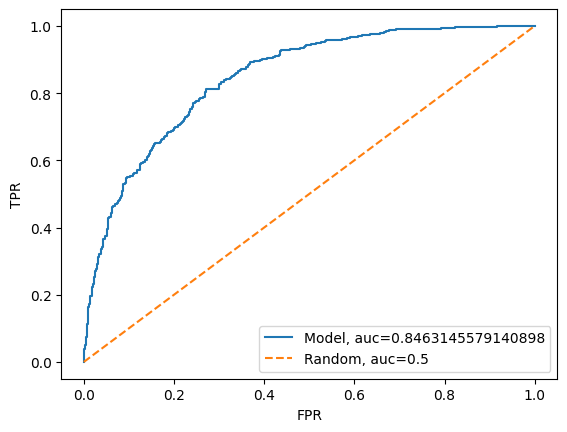

In [23]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)
auc = roc_auc_score(y_val, y_pred)
plt.plot(fpr,tpr,label="Model, auc="+str(auc))
plt.plot([0, 1], [0, 1], label='Random, auc='+str(0.5), linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc=4)
plt.show()

## Cross-validation

**Cross-validation** is a resampling procedure used to estimate how well a model will generalize to unseen data.
Instead of training once on a single split, CV repeatedly splits the training data into multiple folds, trains on some folds, and evaluates on the held-out fold, then averages the scores. This reduces the risk that your evaluation is just “good luck” from a particular split and gives a more stable estimate of performance.

### Key ideas

- **K-Fold CV:** Split data into k equal folds. For each fold: train on k−1 folds, validate on the remaining fold. Report the mean/STD of the metric (e.g., ROC-AUC). Typical k = 5 or 10.

- **Stratified K-Fold:** For classification, keep class proportions similar in every fold. This is the default good choice for churn/imbalanced problems.

- **Repeated CV:** Run K-Fold multiple times with different shuffles to reduce variance further.

- **Leave-One-Out (LOOCV):** k equals the number of samples. Very low bias but high variance and expensive — rarely needed.

- **Time-series:** Do not shuffle; use expanding/rolling splits (e.g., TimeSeriesSplit) to respect temporal order.

- **Use in tuning:** Pair CV with hyperparameter search (Grid/Random/Bayesian). To avoid optimistic bias when comparing pipelines/hyperparameters, use CV inside the search; optionally use nested CV for a fully unbiased comparison.

In [46]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model

In [31]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [ ]:
# K-Fold Cross Validation
kfold = KFold(n_splits=10, shuffle=True, random_state=1)
train_idx, val_idx = next(kfold.split(df_full_train))
print("TRAIN Length:", len(train_idx), ", VAL Length:", len(val_idx))
print("Total Length:", len(df_full_train))

TRAIN Length: 5070 , VAL Length: 564
Total Length: 5634


In [50]:
from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Cross-validation loop - calculate metrics for each fold
scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    
    X_train = df_full_train.iloc[train_idx]
    X_val = df_full_train.iloc[val_idx]
    
    y_train = X_train.churn.values
    y_val = X_val.churn.values
    
    dv, model = train(X_train, y_train)
    y_pred = predict(X_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print("Mean AUC:", round(np.mean(scores), 3), "+-", round(np.std(scores), 3))    

Mean AUC: 0.843 +- 0.012


In [51]:
scores

[0.8498004230078081,
 0.8426516089108912,
 0.8583127086690033,
 0.8333717389515267,
 0.8246122828784119,
 0.8414585414585415,
 0.8431618365353305,
 0.825466476913346,
 0.8458574181117533,
 0.8614164229773789]